# Implementing Custom Kernels

In this notebook we'll demonstrate how one can go about implementing their own custom kernel functions into GPJax. For the purposes of an interesting exposition in this notebook, we'll be considering the case where the underlying data is observed on a circle. In such cases, typical stationary kernels which use Euclidean distance metrics are ill-posed and we must instead use alternative measures of distance whilst ensuring our kernel function is still positive definite.

This post is an adaption of the excellent guide given in the PYMC3 documentation and we would encourage the curious reader to visit their notebook which can be found [here](https://docs.pymc.io/pymc-examples/examples/gaussian_processes/GP-Circular.html).

In [1]:
%load_ext lab_black

In [2]:
import gpjax
import gpjax.core as gpx
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax.random as jr
from jax import grad, jit, value_and_grad
from jax.experimental import optimizers
from helper_fns import fit, plot

key = jr.PRNGKey(123)
print(gpjax.__version__)

0.3.6


## Defining a kernel

Let's get straight into the core of this notebook and define our kernel function. As acknowledged in the introduction, our assumption here is that our data is observed on a disk domain, and it is therefore imprecise to use a regular Euclidean metric to quantify the distance between pairs of points. A natural first thought here may be to replace the Euclidean distance measure with a geodesic metric. However, doing so will often result in a non-positive definite kernel and is therefore non-conformative to a Gaussian process model. Instead, we'll use the following angular distance 
$$d(\theta, \theta') = \lvert (\theta-\theta'+c) \operatorname{mod} 2c - c \rvert$$
where $\theta, \theta'$ constitutes a pair of angles and $c$ is the max distance on the disk between any two points. An efficient implementation is lifted from [StackOverflow](https://stackoverflow.com/questions/1878907/the-smallest-difference-between-2-angles).

In [3]:
def angular_distance(x, y, c):
    return jnp.abs((x - y + c) % (c * 2) - c)

### Kernel preamble

With a distance metric in place, we can now go ahead and define our kernel function. To do so, we'll first define a thin `dataclass` named `Polar`. This is purely to ensure that all required arguments preceed the kernel's optional arguments when we inerit the `Kernel` dataclass in our new kernel. From here, the next step required is to define the kernel's max angular distance parameter `c` which we do through a `__post_init__` method as `c` is, by definition, just half the functions periodicity length. 

### Kernel body

Finally, we must define the kernel's `__call__` method to instruct GPJax how to compute the covariance matrix. To achieve this, we use the $\mathcal{C}^2$-Wendland kernel 
$$ W_c(\theta, \theta') = \left\lvert \left(1 + \tau \frac{d(\theta, \theta')}{c} \right) \left(1 - \frac{d(\theta, \theta')}{c} \right)^{\tau} \right\rvert \quad \tau \geq 4 \tag{1}.$$
In this kernel, the value of $\tau$ governs the correlation between observations. The smaller the value of $\tau$, the more strongly points are correlated with one another. For more details on the Wendland kernel and it's application to polar Gaussian processes, we'd point the interested reader to [Padonou & Roustant (2015)](https://hal.inria.fr/hal-01119942v1).

In [4]:
from gpjax.kernels import Kernel
from typing import Optional
from chex import dataclass


@dataclass(repr=False)
class Polar:
    period: float


@dataclass(repr=False)
class Wendland(Kernel, Polar):
    """
    https://hal.archives-ouvertes.fr/hal-01119942v1/document
    """

    period: float
    ndims: Optional[int] = 1
    stationary: Optional[bool] = True
    spectral: Optional[bool] = False
    name: Optional[str] = "Circular kernel"

    def __post_init__(self):
        self.c = self.period / 2.0  # in [0, \pi]

    def __call__(
        self, x: jnp.DeviceArray, y: jnp.DeviceArray, params: dict
    ) -> jnp.DeviceArray:
        tau = params["tau"]
        t = angular_distance(x, y, self.c)
        K = (1 + tau * t / self.c) * jnp.clip(1 - t / self.c, 0, jnp.inf) ** tau
        return K.squeeze()

## Parameter handling

When optimising the Gaussian process that is defined in terms of the Wendland function, we treat $\tau$ as a model parameter that we seek to optimise the marginal log-likelihood with respect to. As such, we must include it in the kernel's `initialise` function. [Multiple dispatch](https://en.wikipedia.org/wiki/Multiple_dispatch) is used for consistent initialisation usage, and this approach makes it straightforward to define the required `initialise` function as follows.

In [5]:
from multipledispatch import dispatch


@dispatch(Wendland)
def initialise(kernel: Wendland):
    return {"tau": jnp.array([4.0])}  # \tau >= 4

The only thing left to do now is define a bijection for the kernel's smoothness parameter $\tau$. As stated in (1), the value of $\tau$ must be greater than or equal to 4. Therefore, to ensure stable optimisation, we must assign the parameter a bijection that maps $\mathbb{R}_{\geq 4} \rightarrow \mathbb{R}$. To achieve this, we can use a clipped softplus function from Tensorflow Probability in the two lines that follow.

In [6]:
from gpjax.config import add_parameter
from tensorflow_probability.substrates.jax import bijectors as tfb

configs = gpx.get_defaults()
configs = add_parameter(configs, ("tau", tfb.Softplus(low=jnp.array(4.0))))

## Modelling

We'll now compare the effect of this new Wendland kernel against a more typical RBF kernel for some data observed on a disk and see what, if any, additional performance this new kernel structure gives us.

### Data

Let us first simulate an arbitary dataset that contains a set of 20 observations, each perturbed by some Gaussian noise $\sigma \sim \mathcal{N}(0, 0.2)$. Once realised, we'll collect our observation pairs up into GPJax's `Dataset` dataclass.

In [7]:
angles = jnp.linspace(0, 2 * jnp.pi, num=200).reshape(-1, 1)
n = 20
noise = 0.2

X = jnp.sort(jr.uniform(key, minval=0.0, maxval=jnp.pi * 2, shape=(n, 1)), axis=0)
y = 4 + jnp.cos(2 * X) + jr.normal(key, shape=X.shape) * noise
training = gpx.Dataset(X=X, y=y)

### Kernel instantiation

Our data is observed on the full circle, so the data's periodicity length is $2\pi$ and, equipped with this information, we can define our Wendland kernel.

In [8]:
w_kern = Wendland(period=2 * jnp.pi)

### Posterior realisation

We'll now define two Gaussian process posteriors: one with our new Wendland kernel and another with an RBF kernel. We'll then optimise the Gaussian process' marginal log-likelihood with respect to the kernel parameters and the model's noise term using the `fit` function. The full form of this function is omitted for brevity, however it simply ingests a posterior Gaussian process, a training dataset, and a configuration dictionary and returns an optimised set of parameters.

In [9]:
circlular_posterior = gpx.Prior(kernel=w_kern) * gpx.Gaussian()
circular_params = fit(circlular_posterior, nits=500, data=training, configs=configs)

rbf_posterior = gpx.Prior(kernel=gpx.RBF()) * gpx.Gaussian()
rbf_params = fit(rbf_posterior, nits=500, data=training, configs=configs)

Circular kernel GP's marginal log-likelihood:  29.83
Radial basis function kernel GP's marginal log-likelihood:  25.42


### Preditive random variable

The predictive distribution for both our posterior Gaussian processes is now defined where we use a linear space of _angles_ defined on $[0, 2\pi]$ as a test set.

In [10]:
circular_rv = gpx.random_variable(
    circlular_posterior, circular_params, training, jitter_amount=1e-6
)(angles)

rbf_rv = gpx.random_variable(rbf_posterior, rbf_params, training, jitter_amount=1e-6)(
    angles
)

Using a second helper function that draws a set of 50 samples from the posterior, computes the posterior mean and variances before plotting these three quantities along with the underlying training data is used to visualise the pair of Gaussian process models.

Text(0.5, 1.0, 'RBF Kernel')

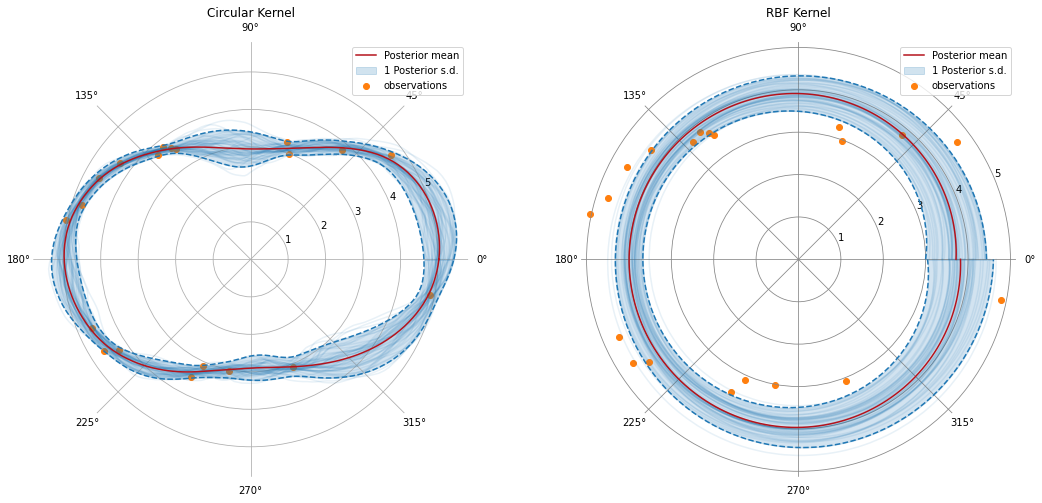

In [11]:
from helper_fns import plot

fig = plt.figure(figsize=(18, 8))
gridspec = fig.add_gridspec(1, 2)

ax1 = plt.subplot(gridspec[0], polar=True)
ax2 = plt.subplot(gridspec[1], polar=True)
plot(key, circular_rv, angles, training, ax1, n_samples=50)
plot(key, rbf_rv, angles, training, ax2, n_samples=50)
ax1.set_title("Circular Kernel")
ax2.set_title("RBF Kernel")

As we can see in the right panel, the RBF kernel has done a poor job in capturing the latent function. However, the RBF kernel is also incapable of wrapping around the entire domain, as can be seen by the discontinuity at $0^{\scriptsize\textit{O}}$. Conversely, the Wendland kernel has done an excellent job at accurately recovering the latent function with a predictive mean that almost perfectly passes through the training set and seemingly well-calibrated posterior uncertainties, as seen through the large sample path variability in regions void of any training data.

In this notebook we've demonstrated how one can easily go about extending GPJax to incorporate their own kernel functions. Many of the principles discussed here, such as the initialisation and bijection statement, are principles that carry across the entire package, so the framework covered here is equally relevant for defining custom likelihoods, GP priors and posteriors, mean functions and sampling functions. 

## System information

In [12]:
%load_ext watermark
%watermark -n -u -v -iv -w -a "Thomas Pinder"

gpjax 0.3.6
Thomas Pinder 
last updated: Fri May 07 2021 

CPython 3.6.9
IPython 7.16.1
watermark 2.0.2
